In [569]:
!pip install matplotlib

In [570]:
!pip install matplotlib-inline

## Setup

In [571]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [572]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import Metadata
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [573]:
import json

## Preprocessing

### General Info about Data

In [574]:
df = pd.read_csv("../data/mental_health_dataset.csv")

In [575]:
df.head()

,User_ID,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours
0,1,36,Non-binary,Sales,Canada,No,Medium,Yes,Medium,7.1,46,5
1,2,34,Female,Education,UK,Yes,NaN,No,Low,7.5,47,8
2,3,65,Non-binary,Sales,USA,Yes,High,No,Low,8.4,58,10
3,4,34,Male,Other,Australia,No,Low,No,Medium,9.8,30,2
4,5,22,Female,Healthcare,Canada,Yes,Low,No,Medium,4.9,62,5


In [576]:
df['Gender'].value_counts()

Gender
Female               270
Non-binary           267
Male                 247
Prefer not to say    216
Name: count, dtype: int64

In [577]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_ID                  1000 non-null   int64  
 1   Age                      1000 non-null   int64  
 2   Gender                   1000 non-null   object 
 3   Occupation               1000 non-null   object 
 4   Country                  1000 non-null   object 
 5   Mental_Health_Condition  1000 non-null   object 
 6   Severity                 499 non-null    object 
 7   Consultation_History     1000 non-null   object 
 8   Stress_Level             1000 non-null   object 
 9   Sleep_Hours              1000 non-null   float64
 10  Work_Hours               1000 non-null   int64  
 11  Physical_Activity_Hours  1000 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 93.9+ KB


In [578]:
df = df.drop(columns=['User_ID']) # not needed

In [579]:
df.shape

(1000, 11)

Mental Health Condition is the target variable.

In [580]:
df['Mental_Health_Condition'].value_counts()

Mental_Health_Condition
Yes    515
No     485
Name: count, dtype: int64

### EDA

*Univariate Analysis*

Text(0.5, 1.0, 'Mental Health Distribution')

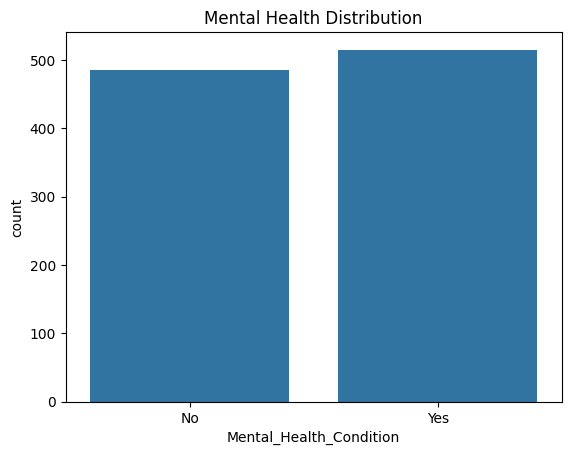

In [581]:
# mental health distribution
sns.countplot(data=df, x='Mental_Health_Condition')
plt.title('Mental Health Distribution')

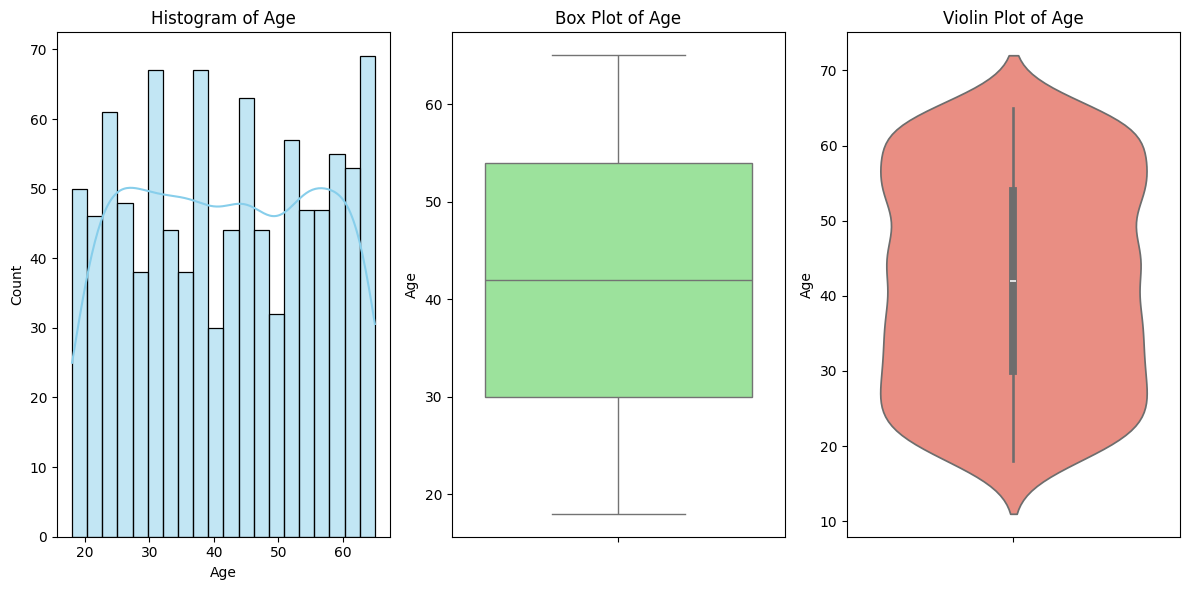

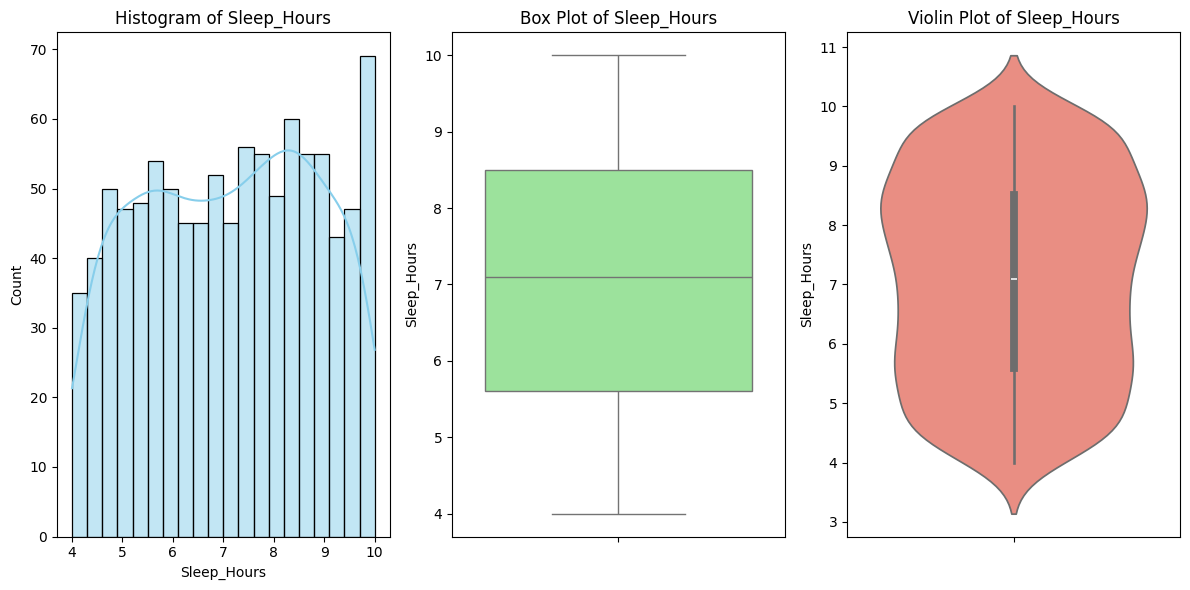

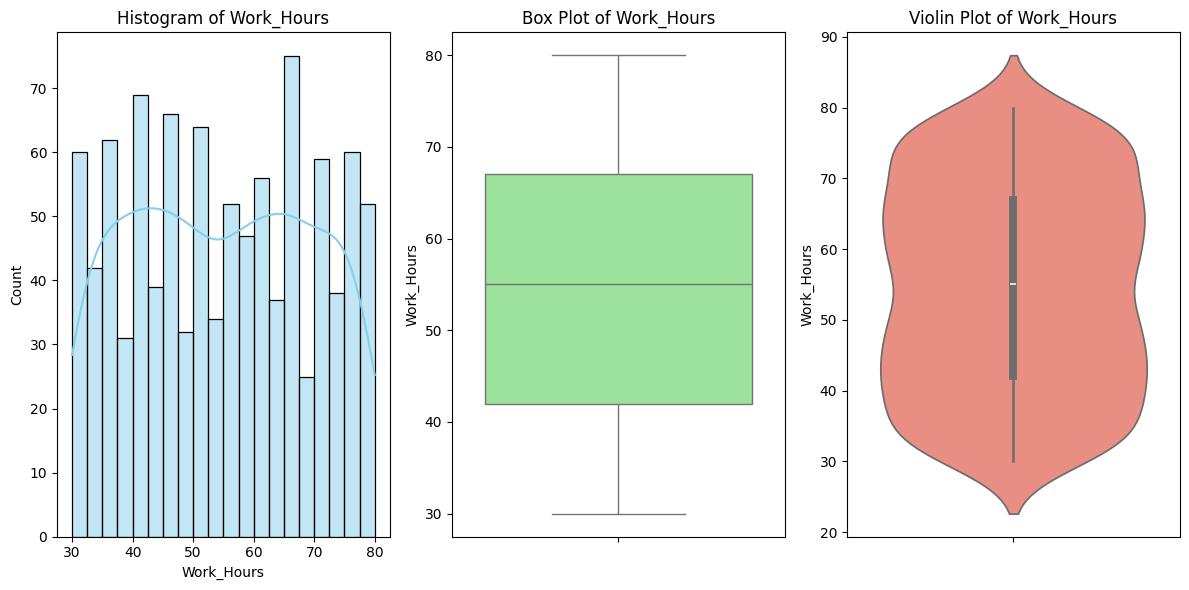

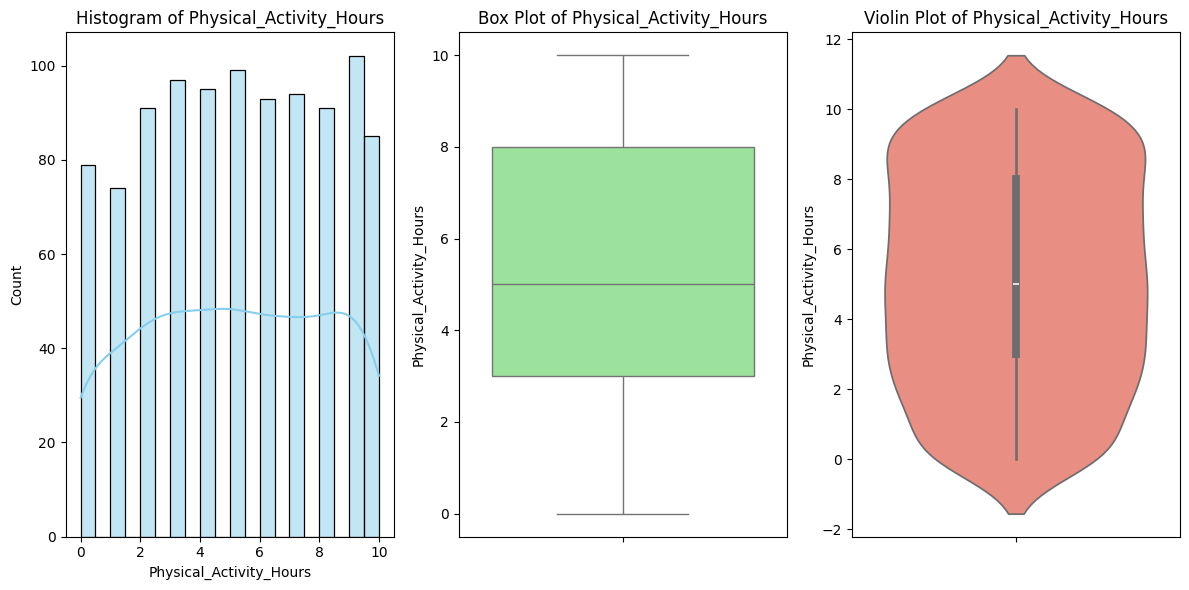

In [582]:
# numerical Variables
numerical_columns = ['Age', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours']

for col in numerical_columns:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Histogram of {col}')

    plt.subplot(1, 3, 2)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'Box Plot of {col}')

    plt.subplot(1, 3, 3)
    sns.violinplot(y=df[col], color='salmon')
    plt.title(f'Violin Plot of {col}')

    plt.tight_layout()
    plt.show()

Data contains people of ages between ~20 and ~60, mostly surveyed peoples sleep hours are between 8-10 hours while their work and physical activity hours vary a lot.

Seems like there are no outliers.

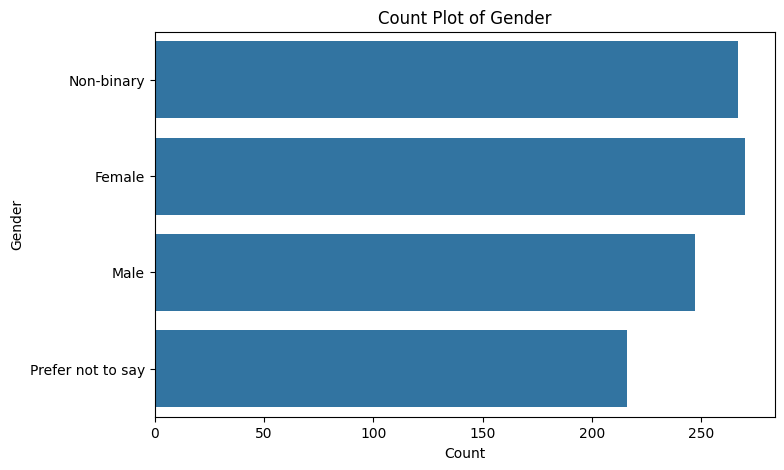

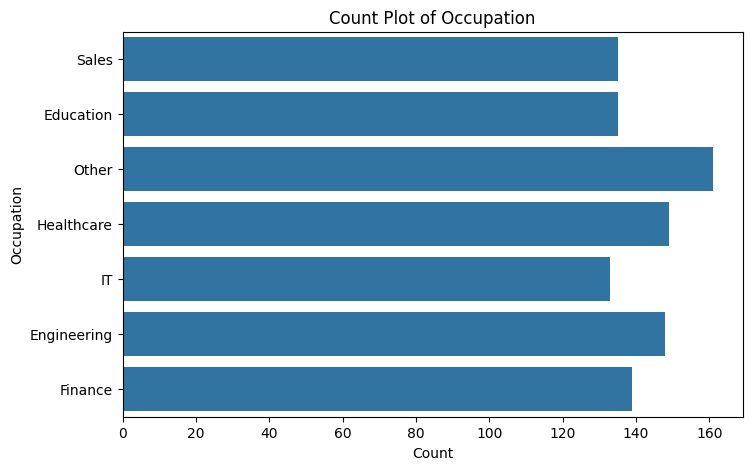

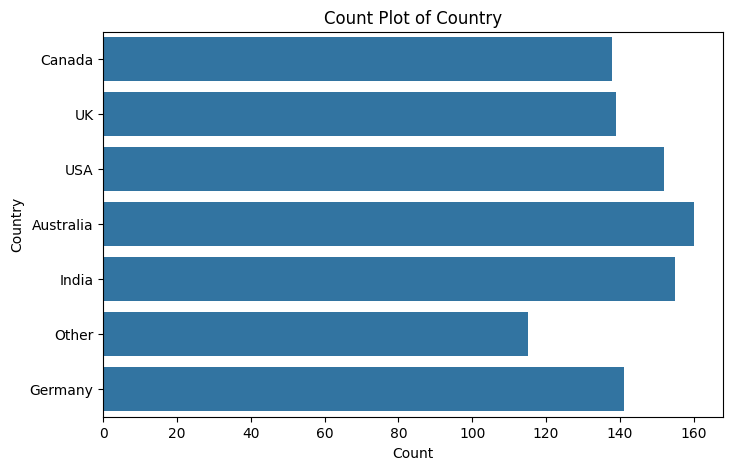

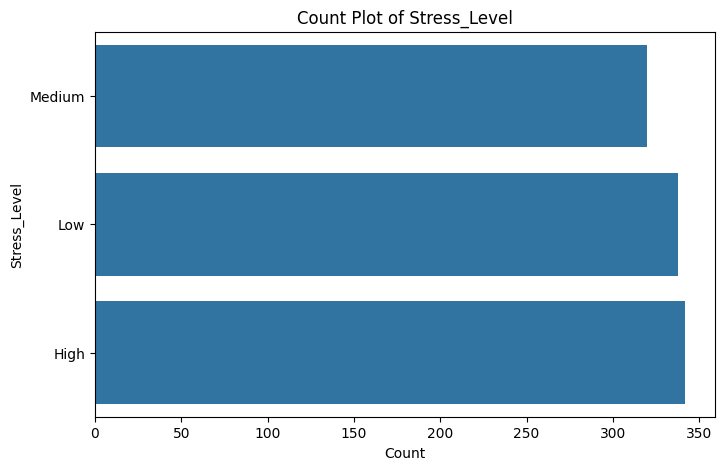

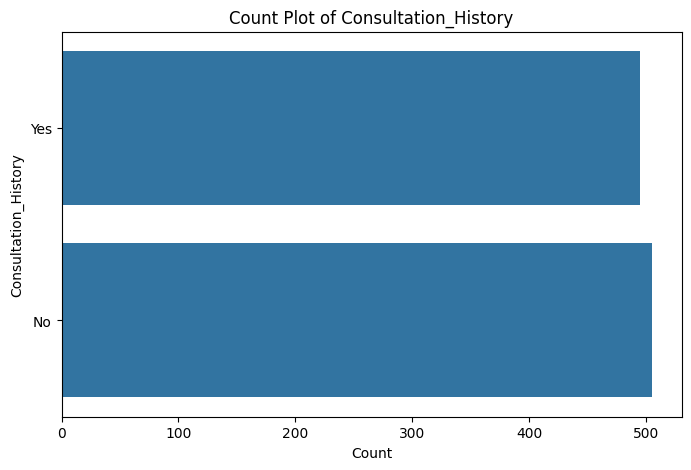

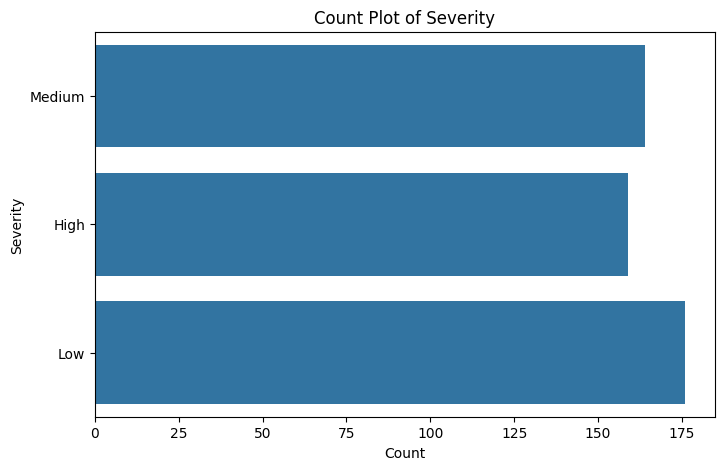

In [583]:
# categorical Variables
categorical_columns = ['Gender', 'Occupation', 'Country', 'Stress_Level', 'Consultation_History', 'Severity']

for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(y=col, data=df)
    plt.title(f'Count Plot of {col}')
    plt.ylabel(col)
    plt.xlabel('Count')
    plt.show()

*Bivariate Analysis*

Text(0.5, 1.0, 'Stress Level Distribution according to Genders')

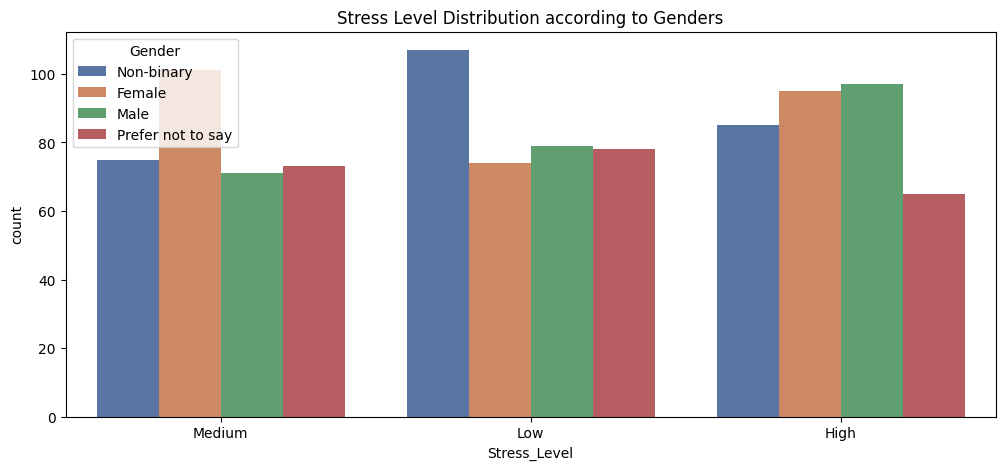

In [584]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='Stress_Level', palette='deep', hue='Gender')
plt.title('Stress Level Distribution according to Genders')

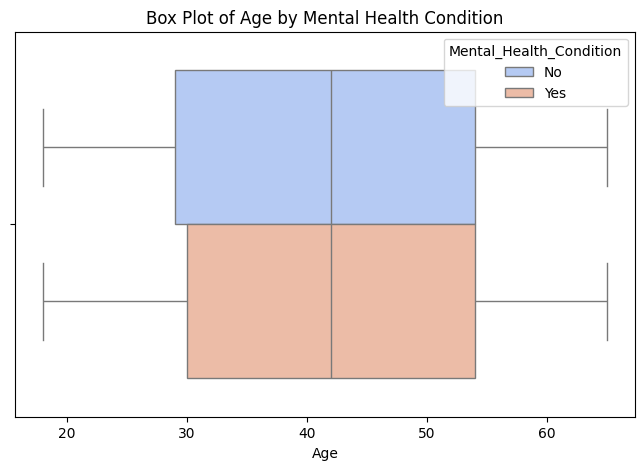

In [585]:
# Box plots of Age grouped by Mental_Health_Condition
plt.figure(figsize=(8, 5))
sns.boxplot(x='Age', data=df, palette='coolwarm', hue='Mental_Health_Condition')
plt.title('Box Plot of Age by Mental Health Condition')
plt.show()

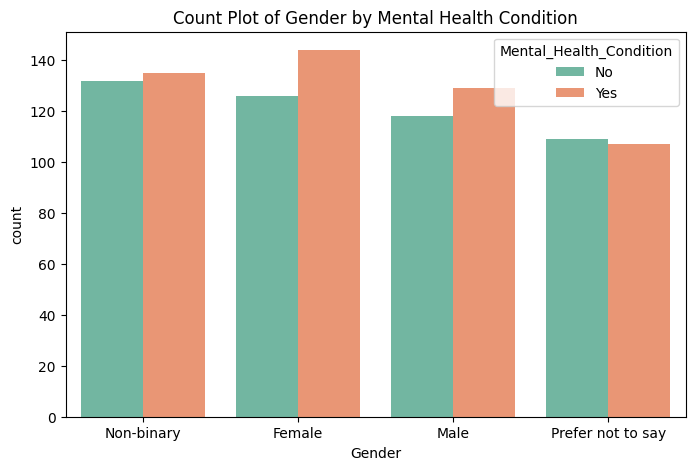

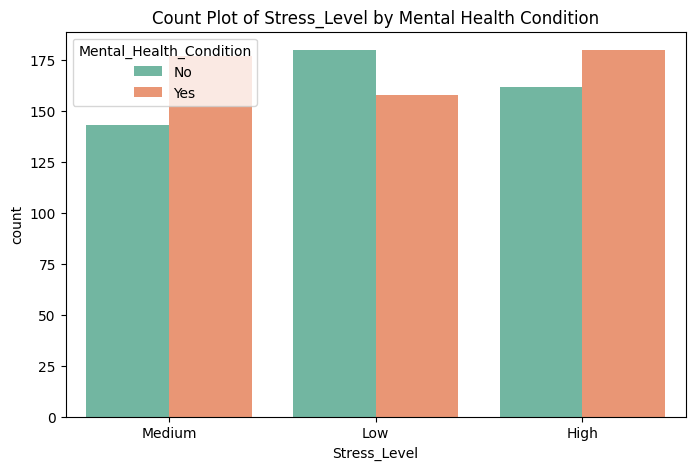

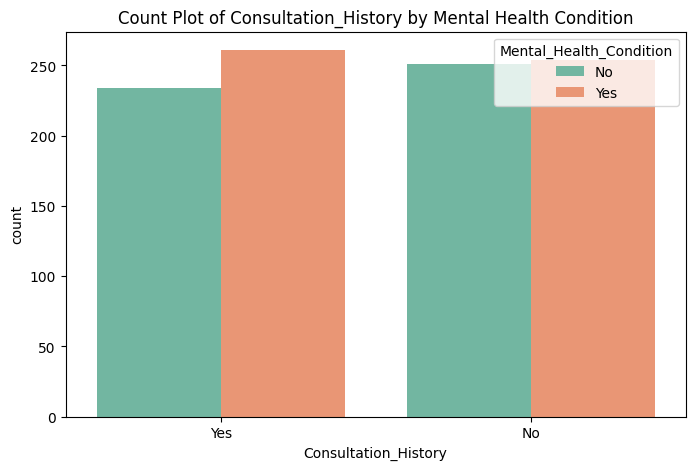

In [586]:
# count plots for Gender, Stress_Level, and Consultation_History against Mental_Health_Condition
for col in ['Gender', 'Stress_Level', 'Consultation_History']:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, hue='Mental_Health_Condition', data=df, palette='Set2')
    plt.title(f'Count Plot of {col} by Mental Health Condition')
    plt.show()

*Correlation Analysis*

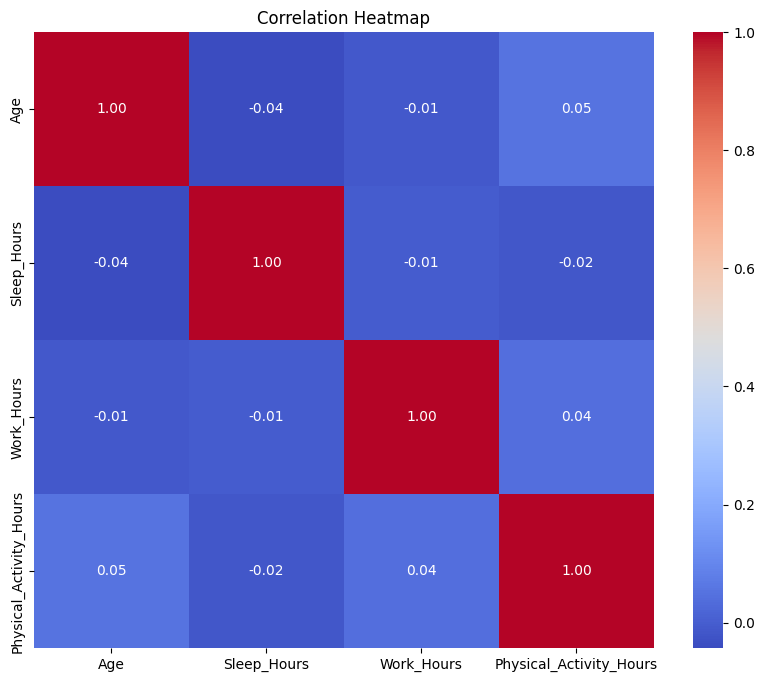

In [587]:
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Correlations are not high at all.

*Missing Values Analysis*

In [588]:
missing_values = df.isnull().sum()
print("Missing Values per Column:")
print(missing_values)

Missing Values per Column:
Age                          0
Gender                       0
Occupation                   0
Country                      0
Mental_Health_Condition      0
Severity                   501
Consultation_History         0
Stress_Level                 0
Sleep_Hours                  0
Work_Hours                   0
Physical_Activity_Hours      0
dtype: int64


Severity has a lot of missing values.

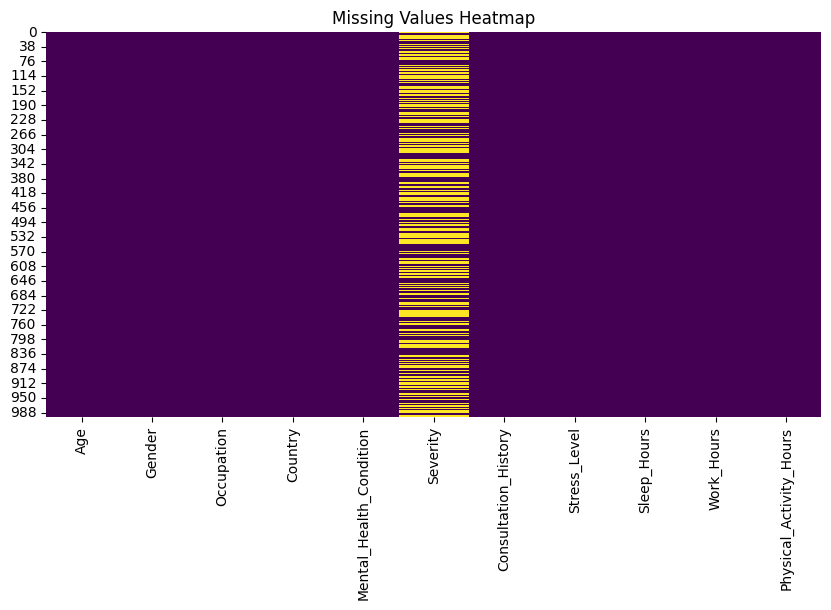

In [589]:
# visualize missing values
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

*Five-Number Summary*

In [590]:
for col in numerical_columns:
    print(f"\nFive-Number Summary for {col}:")
    print(df[col].describe())


Five-Number Summary for Age:
count    1000.00000
mean       41.89200
std        13.97475
min        18.00000
25%        30.00000
50%        42.00000
75%        54.00000
max        65.00000
Name: Age, dtype: float64

Five-Number Summary for Sleep_Hours:
count    1000.000000
mean        7.095600
std         1.713861
min         4.000000
25%         5.600000
50%         7.100000
75%         8.500000
max        10.000000
Name: Sleep_Hours, dtype: float64

Five-Number Summary for Work_Hours:
count    1000.000000
mean       54.621000
std        14.709035
min        30.000000
25%        42.000000
50%        55.000000
75%        67.000000
max        80.000000
Name: Work_Hours, dtype: float64

Five-Number Summary for Physical_Activity_Hours:
count    1000.000000
mean        5.134000
std         3.081808
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: Physical_Activity_Hours, dtype: float64


In [591]:
data_types = df.dtypes
print("\nData Types:")
print(data_types)


Data Types:
Age                          int64
Gender                      object
Occupation                  object
Country                     object
Mental_Health_Condition     object
Severity                    object
Consultation_History        object
Stress_Level                object
Sleep_Hours                float64
Work_Hours                   int64
Physical_Activity_Hours      int64
dtype: object


It would be better to classify "object"s into categorical or ordinal.

## Data Preprocessing

*Handling Missing Values*

In [592]:
df['Severity'].value_counts()

Severity
Low       176
Medium    164
High      159
Name: count, dtype: int64

In [593]:
severity_data = df[~df['Severity'].isnull()]  # rows with non-missing Severity
missing_severity = df[df['Severity'].isnull()]  # rows with missing Severity

In [594]:
missing_severity

,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours
1,34,Female,Education,UK,Yes,NaN,No,Low,7.5,47,8
8,25,Male,Education,USA,Yes,NaN,No,Medium,6.7,67,9
9,65,Non-binary,Healthcare,India,No,NaN,Yes,Low,8.9,57,6
10,52,Female,Other,India,No,NaN,No,Medium,8.3,79,10
11,23,Male,Engineering,Canada,Yes,NaN,No,High,5.7,57,2
...,...,...,...,...,...,...,...,...,...,...,...
989,49,Female,Finance,USA,No,NaN,No,High,9.7,64,2
994,56,Non-binary,Finance,Canada,Yes,NaN,No,High,7.5,75,8
995,46,Non-binary,Other,Germany,No,NaN,Yes,Low,9.3,50,0
996,31,Male,Sales,Canada,No,NaN,No,High,4.5,37,6


In [595]:
encoder = LabelEncoder()

In [596]:
pd.options.mode.chained_assignment = None  # default='warn'

In [597]:
severity_data['Severity_Encoded'] = encoder.fit_transform(severity_data['Severity'])
severity_data

,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Severity_Encoded
0,36,Non-binary,Sales,Canada,No,Medium,Yes,Medium,7.1,46,5,2
2,65,Non-binary,Sales,USA,Yes,High,No,Low,8.4,58,10,0
3,34,Male,Other,Australia,No,Low,No,Medium,9.8,30,2,1
4,22,Female,Healthcare,Canada,Yes,Low,No,Medium,4.9,62,5,1
5,64,Non-binary,IT,UK,Yes,High,No,High,6.3,34,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
991,40,Non-binary,IT,UK,No,High,Yes,Low,8.2,67,9,0
992,52,Female,Education,Canada,Yes,High,No,Medium,7.9,57,2,0
993,50,Prefer not to say,Sales,Canada,No,Medium,Yes,Medium,4.8,71,10,2
997,33,Female,IT,Germany,No,High,Yes,Medium,9.7,73,10,0


In [598]:
features = df.drop(columns = ['Severity'])

In [599]:
# one-hot encode categorical features for predictive model
features_encoded = pd.get_dummies(features, drop_first=True)
features_encoded

,Age,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Occupation_Engineering,Occupation_Finance,Occupation_Healthcare,...,Country_Canada,Country_Germany,Country_India,Country_Other,Country_UK,Country_USA,Mental_Health_Condition_Yes,Consultation_History_Yes,Stress_Level_Low,Stress_Level_Medium
0,36,7.1,46,5,False,True,False,False,False,False,...,True,False,False,False,False,False,False,True,False,True
1,34,7.5,47,8,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
2,65,8.4,58,10,False,True,False,False,False,False,...,False,False,False,False,False,True,True,False,True,False
3,34,9.8,30,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,22,4.9,62,5,False,False,False,False,False,True,...,True,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,46,9.3,50,0,False,True,False,False,False,False,...,False,True,False,False,False,False,False,True,True,False
996,31,4.5,37,6,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
997,33,9.7,73,10,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,True
998,42,6.5,79,8,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True


In [600]:
severity_data_encoded = features_encoded.loc[severity_data.index]
missing_severity_encoded = features_encoded.loc[missing_severity.index]

In [601]:
missing_severity_encoded

,Age,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Occupation_Engineering,Occupation_Finance,Occupation_Healthcare,...,Country_Canada,Country_Germany,Country_India,Country_Other,Country_UK,Country_USA,Mental_Health_Condition_Yes,Consultation_History_Yes,Stress_Level_Low,Stress_Level_Medium
1,34,7.5,47,8,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
8,25,6.7,67,9,True,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
9,65,8.9,57,6,False,True,False,False,False,True,...,False,False,True,False,False,False,False,True,True,False
10,52,8.3,79,10,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
11,23,5.7,57,2,True,False,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,49,9.7,64,2,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
994,56,7.5,75,8,False,True,False,False,True,False,...,True,False,False,False,False,False,True,False,False,False
995,46,9.3,50,0,False,True,False,False,False,False,...,False,True,False,False,False,False,False,True,True,False
996,31,4.5,37,6,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [602]:
X = severity_data_encoded
y = severity_data['Severity_Encoded']

In [603]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

RandomForestClassifier(random_state=42)

In [604]:
predicted_severity = rf_model.predict(missing_severity_encoded)
predicted_severity

array([1, 1, 2, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 2, 2, 1, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1, 1, 2, 0, 0, 0, 1,
       2, 2, 2, 1, 0, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 2, 1, 0, 2, 2, 1, 0,
       2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 1,
       0, 0, 0, 2, 2, 1, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 1, 1, 0, 0, 2, 0,
       1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 2, 0, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2,
       2, 0, 1, 2, 0, 0, 1, 0, 2, 0, 2, 2, 0, 1, 0, 1, 2, 1, 0, 0, 0, 1,
       0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2,
       0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 1, 0, 1, 1, 0,
       0, 1, 0, 2, 1, 2, 1, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 1,
       1, 2, 0, 2, 2, 1, 2, 2, 1, 0, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       2, 0, 2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 1, 2, 2, 0,
       2, 0, 2, 0, 2, 1, 1, 2, 2, 0, 2, 1, 1, 1, 0,

In [605]:
missing_severity['Severity'] = encoder.inverse_transform(predicted_severity)
missing_severity

,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours
1,34,Female,Education,UK,Yes,Low,No,Low,7.5,47,8
8,25,Male,Education,USA,Yes,Low,No,Medium,6.7,67,9
9,65,Non-binary,Healthcare,India,No,Medium,Yes,Low,8.9,57,6
10,52,Female,Other,India,No,High,No,Medium,8.3,79,10
11,23,Male,Engineering,Canada,Yes,Low,No,High,5.7,57,2
...,...,...,...,...,...,...,...,...,...,...,...
989,49,Female,Finance,USA,No,High,No,High,9.7,64,2
994,56,Non-binary,Finance,Canada,Yes,Medium,No,High,7.5,75,8
995,46,Non-binary,Other,Germany,No,Low,Yes,Low,9.3,50,0
996,31,Male,Sales,Canada,No,High,No,High,4.5,37,6


In [606]:
df.loc[missing_severity.index, 'Severity'] = missing_severity['Severity']

In [607]:
df.drop(columns=['Severity_Encoded'], inplace=True, errors='ignore')

*Feature Engineering*

In [608]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      1000 non-null   int64  
 1   Gender                   1000 non-null   object 
 2   Occupation               1000 non-null   object 
 3   Country                  1000 non-null   object 
 4   Mental_Health_Condition  1000 non-null   object 
 5   Severity                 1000 non-null   object 
 6   Consultation_History     1000 non-null   object 
 7   Stress_Level             1000 non-null   object 
 8   Sleep_Hours              1000 non-null   float64
 9   Work_Hours               1000 non-null   int64  
 10  Physical_Activity_Hours  1000 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 86.1+ KB


In [609]:
df.head()

,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours
0,36,Non-binary,Sales,Canada,No,Medium,Yes,Medium,7.1,46,5
1,34,Female,Education,UK,Yes,Low,No,Low,7.5,47,8
2,65,Non-binary,Sales,USA,Yes,High,No,Low,8.4,58,10
3,34,Male,Other,Australia,No,Low,No,Medium,9.8,30,2
4,22,Female,Healthcare,Canada,Yes,Low,No,Medium,4.9,62,5


In [610]:
bins = [17, 30, 50, 66]
labels = ['Young', 'Middle-aged', 'Senior']
df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

In [611]:
stress_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
df['Stress_Level_Mapped'] = df['Stress_Level'].map(stress_mapping)
df['Work_Stress_Index'] = df['Stress_Level_Mapped'] * df['Work_Hours']
df.drop(['Stress_Level_Mapped'], axis=1, inplace=True)

In [612]:
df['Physical_Activity_Stress_Index'] = df['Physical_Activity_Hours'] * df['Work_Stress_Index']

In [613]:
df.head()

,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Work_Stress_Index,Physical_Activity_Stress_Index
0,Middle-aged,Non-binary,Sales,Canada,No,Medium,Yes,Medium,7.1,46,5,92,460
1,Middle-aged,Female,Education,UK,Yes,Low,No,Low,7.5,47,8,47,376
2,Senior,Non-binary,Sales,USA,Yes,High,No,Low,8.4,58,10,58,580
3,Middle-aged,Male,Other,Australia,No,Low,No,Medium,9.8,30,2,60,120
4,Young,Female,Healthcare,Canada,Yes,Low,No,Medium,4.9,62,5,124,620


Discretizing continuous variables:

In [614]:
df['Sleep_Hours'].value_counts().sort_index()

Sleep_Hours
4.0      7
4.1     11
4.2     17
4.3     11
4.4     13
        ..
9.6     14
9.7     20
9.8     16
9.9     26
10.0     7
Name: count, Length: 61, dtype: int64

In [615]:
bins = [4.0, 6.0, 8.0, 10.0]
labels = ['Low', 'Medium', 'High']
df['Sleep_Hours'] = pd.cut(df['Sleep_Hours'], bins=bins, labels=labels, include_lowest=True)

In [616]:
df['Work_Hours'].value_counts().sort_index()

Work_Hours
30    25
31    22
32    13
33    25
34    17
35    19
36    19
37    24
38    17
39    14
40    29
41    17
42    23
43    21
44    18
45    22
46    23
47    21
48    16
49    16
50    29
51    16
52    19
53    20
54    14
55    11
56    19
57    22
58    24
59    23
60    13
61    18
62    25
63    20
64    17
65    18
66    26
67    31
68    12
69    13
70    18
71    22
72    19
73    22
74    16
75    19
76    25
77    16
78    19
79    17
80    16
Name: count, dtype: int64

In [617]:
df['Work_Hours'], bin_edges = pd.qcut(
    df['Work_Hours'],
    q=3,
    labels=['Low', 'Medium', 'High'],
    retbins=True
)

In [618]:
with open('mental_work_hours_bins.json', 'w') as f:
    json.dump(bin_edges.tolist(), f)

In [619]:
df['Physical_Activity_Hours'].value_counts().sort_index()

Physical_Activity_Hours
0      79
1      74
2      91
3      97
4      95
5      99
6      93
7      94
8      91
9     102
10     85
Name: count, dtype: int64

In [620]:
bins = [0, 3, 7, 10]
labels = ['Low', 'Moderate', 'High']
df['Physical_Activity_Hours'] = pd.cut(df['Physical_Activity_Hours'], bins=bins, labels=labels, include_lowest=True)

In [621]:
df['Work_Stress_Index'].value_counts().sort_index()

Work_Stress_Index
30      4
31     10
32      5
33      9
34      2
       ..
228    10
231     4
234     5
237     5
240     5
Name: count, Length: 130, dtype: int64

In [622]:
bins = [30, 100, 170, 240]
labels = ['Low', 'Medium', 'High']
df['Work_Stress_Index'] = pd.cut(df['Work_Stress_Index'], bins=bins, labels=labels, include_lowest=True)

In [623]:
df['Physical_Activity_Stress_Index'].value_counts().sort_index()

Physical_Activity_Stress_Index
0       79
33       1
36       1
37       1
40       1
        ..
2160     2
2190     2
2280     1
2340     1
2370     1
Name: count, Length: 437, dtype: int64

In [624]:
bins = [0, 100, 1000, 2370]
labels = ['Low', 'Medium', 'High']
df['Physical_Activity_Stress_Index'] = pd.cut(df['Physical_Activity_Stress_Index'], bins=bins, labels=labels, include_lowest=True)

In [625]:
df.head()

,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Work_Stress_Index,Physical_Activity_Stress_Index
0,Middle-aged,Non-binary,Sales,Canada,No,Medium,Yes,Medium,Medium,Low,Moderate,Low,Medium
1,Middle-aged,Female,Education,UK,Yes,Low,No,Low,Medium,Medium,High,Low,Medium
2,Senior,Non-binary,Sales,USA,Yes,High,No,Low,High,Medium,High,Low,Medium
3,Middle-aged,Male,Other,Australia,No,Low,No,Medium,High,Low,Low,Low,Medium
4,Young,Female,Healthcare,Canada,Yes,Low,No,Medium,Low,Medium,Moderate,Medium,Medium


*Encoding Categorical Features*

In [626]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Age                             1000 non-null   category
 1   Gender                          1000 non-null   object  
 2   Occupation                      1000 non-null   object  
 3   Country                         1000 non-null   object  
 4   Mental_Health_Condition         1000 non-null   object  
 5   Severity                        1000 non-null   object  
 6   Consultation_History            1000 non-null   object  
 7   Stress_Level                    1000 non-null   object  
 8   Sleep_Hours                     1000 non-null   category
 9   Work_Hours                      1000 non-null   category
 10  Physical_Activity_Hours         1000 non-null   category
 11  Work_Stress_Index               1000 non-null   category
 12  Physical_Activity_Str

In [627]:
# Convert columns to categorical
df = df.astype('category')

In [628]:
le = LabelEncoder()

In [629]:
# Dictionary to store mappings for all columns
label_mappings = {}

In [630]:
for col in df.columns:
    # Fit and transform the column
    df[col] = le.fit_transform(df[col])
    
    # Save the mapping for the column
    label_mappings[col] = {label: int(index) for index, label in enumerate(le.classes_)}

# Save the mappings to a JSON file
with open('mental_label_mappings.json', 'w') as f:
    json.dump(label_mappings, f, indent=4)

print("Label mappings saved to mental_label_mappings.json")

Label mappings saved to mental_label_mappings.json


In [565]:
df.head()

,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Work_Stress_Index,Physical_Activity_Stress_Index
0,0,2,6,1,0,2,1,2,2,1,2,1,2
1,0,0,0,5,1,1,0,1,2,2,0,1,2
2,1,2,6,6,1,0,0,1,0,2,0,1,2
3,0,1,5,0,0,1,0,2,0,1,1,1,2
4,2,0,3,1,1,1,0,2,1,2,2,2,2


In [566]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Age                             1000 non-null   int32
 1   Gender                          1000 non-null   int32
 2   Occupation                      1000 non-null   int32
 3   Country                         1000 non-null   int32
 4   Mental_Health_Condition         1000 non-null   int32
 5   Severity                        1000 non-null   int32
 6   Consultation_History            1000 non-null   int32
 7   Stress_Level                    1000 non-null   int32
 8   Sleep_Hours                     1000 non-null   int32
 9   Work_Hours                      1000 non-null   int32
 10  Physical_Activity_Hours         1000 non-null   int32
 11  Work_Stress_Index               1000 non-null   int32
 12  Physical_Activity_Stress_Index  1000 non-null   int32
dtypes: i

*Synthetic Data Generation*

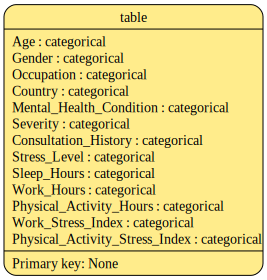

In [567]:
metadata = Metadata.detect_from_dataframe(data=df)
metadata.visualize()

In [568]:
metadata.save_to_json('mental_health_metadata.json')

ValueError: A file named 'mental_health_metadata.json' already exists in this folder. Please specify a different filename.

In [386]:
synthesizer = CTGANSynthesizer(
    metadata=metadata,
    epochs=500,             # train the GAN for 500 epochs
    verbose=True            # display training progress
)

In [387]:
print("Training CTGANSynthesizer...")
synthesizer.fit(df)

Training CTGANSynthesizer...


Gen. (-0.97) | Discrim. (-0.13): 100%|███████████████████████████████████████████████| 500/500 [01:11<00:00,  6.96it/s]


In [388]:
num_synthetic_rows = 500
synthetic_data = synthesizer.sample(num_rows=num_synthetic_rows)

In [389]:
assert list(df.columns) == list(synthetic_data.columns), "Column mismatch!"

In [390]:
final_data = pd.concat([df, synthetic_data], ignore_index=True)

In [391]:
final_data.shape

(1500, 13)

In [392]:
final_data = final_data.drop_duplicates()

In [393]:
final_data.to_csv('../data/final_mental_data.csv', index=False)

*Model-Based Insights*

In [394]:
X = final_data.drop('Mental_Health_Condition', axis=1)
y = final_data['Mental_Health_Condition']

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [396]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [397]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [398]:
print("Top 10 Features:")
print(feature_importance.head(10))

Top 10 Features:
                    Feature  Importance
3                   Country    0.152148
2                Occupation    0.144994
1                    Gender    0.094654
7               Sleep_Hours    0.083105
8                Work_Hours    0.078621
9   Physical_Activity_Hours    0.077724
4                  Severity    0.074620
6              Stress_Level    0.066764
10        Work_Stress_Index    0.065142
0                       Age    0.064987


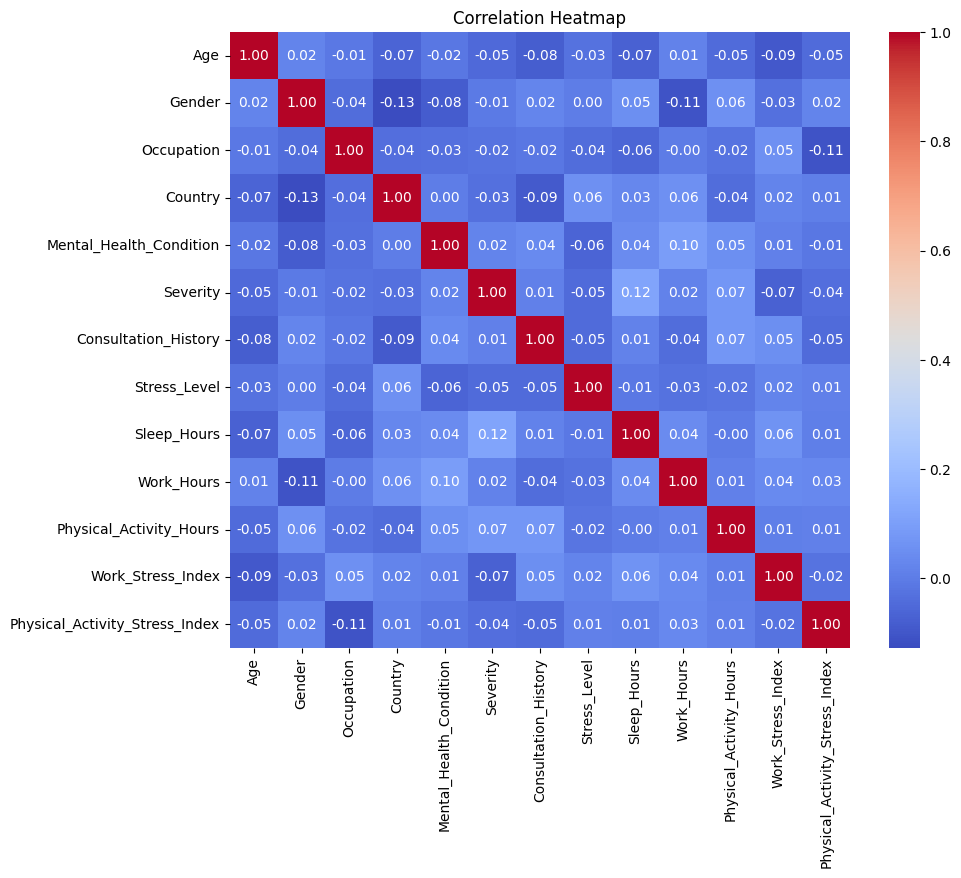

In [399]:
correlation_matrix = synthetic_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [400]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.37      0.39       182
           1       0.59      0.62      0.61       268

    accuracy                           0.52       450
   macro avg       0.50      0.50      0.50       450
weighted avg       0.52      0.52      0.52       450

